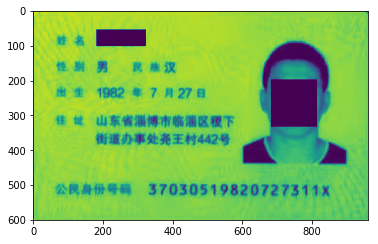

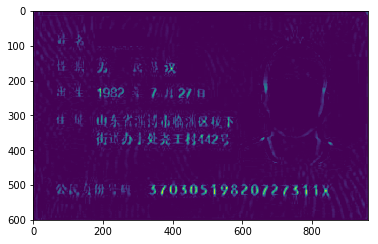

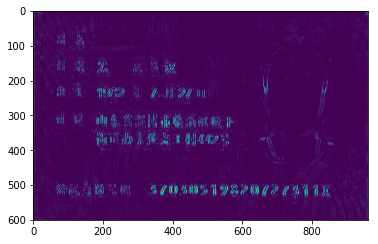

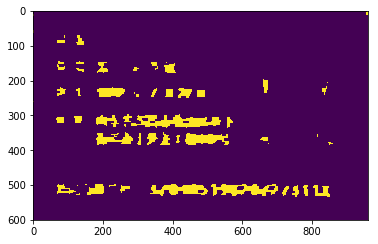

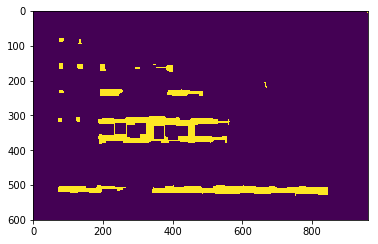

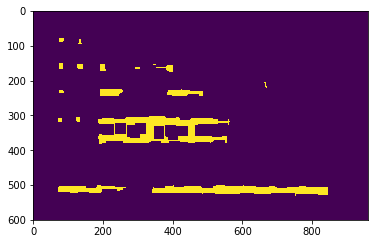

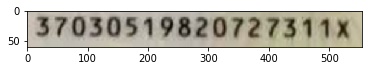

In [23]:
import cv2
import imutils
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np

def findRoi(imagePath):
    
    image = cv2.imread(imagePath)
    image = imutils.resize(image, height=600)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # initialize a rectangular and square structuring kernel
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
    sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
    # smooth the image using a 3x3 Gaussian, then apply the blackhat
    # morphological operator to find dark regions on a light background
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    plt.imshow(gray)
    plt.show()
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
    plt.imshow(blackhat)
    plt.show()
    # compute the Scharr gradient of the blackhat image and scale the
    # result into the range [0, 255]
    gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradX = np.absolute(gradX)
    (minVal, maxVal) = (np.min(gradX), np.max(gradX))
    gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")
    plt.imshow(gradX)
    plt.show()
    # apply a closing operation using the rectangular kernel to close
    # gaps in between letters -- then apply Otsu's thresholding method
    gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
    thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    plt.imshow(thresh)
    plt.show()
    # perform another closing operation, this time using the square
    # kernel to close gaps between lines of the MRZ, then perform a
    # series of erosions to break apart connected components
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
    thresh = cv2.erode(thresh, None, iterations=4)
    plt.imshow(thresh)
    plt.show()
    # during thresholding, it's possible that border pixels were
    # included in the thresholding, so let's set 5% of the left and
    # right borders to zero
    p = int(image.shape[1] * 0.05)
    thresh[:, 0:p] = 0
    thresh[:, image.shape[1] - p:] = 0
    plt.imshow(thresh)
    plt.show()
    # find contours in the thresholded image and sort them by their
    # size
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)[-2]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    
    # loop over the contours
    for c in cnts:
        # compute the bounding box of the contour and use the contour to
        # compute the aspect ratio and coverage ratio of the bounding box
        # width to the width of the image
        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / float(h)
        crWidth = w / float(gray.shape[1])
    
        # print(x, y, w, h)
        # check to see if the aspect ratio and coverage width are within
        # acceptable criteria
        if ar > 15 and crWidth > 0.4:
            # pad the bounding box since we applied erosions and now need
            # to re-grow it
            pX = int((x + w) * 0.03)
            pY = int((y + h) * 0.03)
            (x, y) = (x - pX, y - pY)
            (w, h) = (w + (pX * 2), h + (pY * 2))
    
            # extract the ROI from the image and draw a bounding box
            # surrounding the MRZ
            roi = image[y:y + h, x:x + w].copy()
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            plt.imshow(roi)
            plt.show()
            # break

findRoi("test3.png")